# Root fit analyzing neural network


By Brady Lowe

lowebra2@isu.edu

7/25/2018


This Jupyter notebook was written to both develope and explain how we can use
neural networks to analyze the output of root fits to raw data.

#### Load necessary packages

In [2]:
# Load some packages

# Keras packages for network
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, Conv2D, Flatten
from keras.models import Model
from keras.optimizers import Adam, SGD
# For saving model
from keras.models import model_from_json

# Some items for plotting and drawing
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from PIL import Image
from scipy import misc
import matplotlib.pyplot as plt

# Need numpy
import numpy as np
import nn_utils

%matplotlib inline

Using TensorFlow backend.


#### Load root fit data from file

In [3]:
# Load dataset with m examples
m = -1
train_images, train_labels, test_images, test_labels = nn_utils.load_dataset(m)

# Grab number of images
m_train = train_images.shape[0]
m_test = test_images.shape[0]

# Grab dimensions of picture
h = train_images.shape[1]
w = train_images.shape[2]
c = train_images.shape[3]

# Print dimensions
print("(m_train, height, width, channels): (" + str(m_train) + ", " + str(h) + ", " + str(w) + ", " + str(c) + ")")
print("m_test: " + str(m_test))


(m_train, height, width, channels): (679, 236, 348, 3)
m_test: 85


label: good
label: [1]


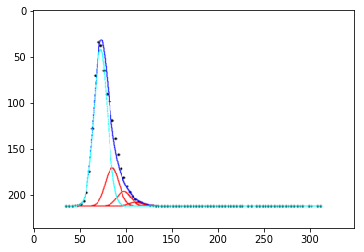

In [9]:
# Print an image
index = 420
this_image = train_images[index]
if train_labels[index] == 1:
    print("label: good")
else:
    print("label: bad")
print("label: " + str(train_labels[index]))
plt.imshow(np.uint8(nn_utils.get_printable_image(this_image)))

## Define and Train 3 layer ConvNet with 2 fully connected layers plus output layer

For the convolutional layer, we will scan over our images with a certain stride and a certain kernal size. 
Each individual scan represents a single neuron in the next layer. Since each scan connects to kernal size squared
neurons below it, convolutions reduce the number of degrees of freedom. Hopefully, through learning the right filters,
we can preserve the important information as we reduce it in size.

Once the image has gone through the convolutional layers (and therefore has been reduced to its features vector), we
can send the resulting vector into some old-fashioned fully-connected layers, and finally into a logistic regression unit.

##### Reshape data for entry into keras convNet

In [63]:
train_images_conv = train_images.reshape(m_train, w, h, c)
test_images_conv = test_images.reshape(m_test, w, h, c)
input_shape = w, h, c
print("successfully reshaped data")

successfully reshaped data


##### Define hyperparameters

In [78]:
# Initialize
filters = []
kernels = []
strides = []
pools = []

# Conv1
filters.append(32)
kernels.append(5)
strides.append(2)
pools.append(2)

# Conv2
filters.append(160)
kernels.append(5)
strides.append(2)
pools.append(2)

# Conv3
filters.append(500)
kernels.append(5)
strides.append(1)
pools.append(2)

# Define dense (fully-connected) layer sizes
fc1 = 30
fc2 = 10

##### Define keras layers (model)

In [79]:
# Define input layer (RGB image matrix)
X = Input(shape=input_shape, name='Input')

# Initialize activation as input
a = X
# Loop through all convolutional layers
for i in range(len(filters)):
    # Perform convolution
    a = Conv2D(filters=filters[i], kernel_size=(kernels[i], kernels[i]), strides=(strides[i], strides[i]), name=('conv' + str(i)))(a)
    # Normalize
    a = BatchNormalization(axis=3, name=('bn' + str(i)))(a)
    # Activate
    a = Activation('relu', name=('a' + str(i)))(a)
    # Max-pool
    a = MaxPooling2D((2, 2), name=('max_pool' + str(i)))(a)

# Flatten output of convNet
a = Flatten()(a)
# Define first fully connected layer
a = Dense(units=fc1, activation='relu', name='fc0')(a)
# Use some dropout here for regularization
a = Dropout(rate=0.5)(a)
# Define second fully connected layer
a = Dense(units=fc2, activation='relu', name='fc1')(a)
# Define output layer 
a = Dense(units=1, activation='sigmoid', name='sigmoid')(a)

# Make the model
conv_model = Model(inputs=X, outputs=a)

# Print summary
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 348, 236, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 172, 116, 32)      2432      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 172, 116, 32)      128       
_________________________________________________________________
a0 (Activation)              (None, 172, 116, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 86, 58, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 41, 27, 160)       128160    
_________________________________________________________________
bn1 (BatchNormalization)     (None, 41, 27, 160)       640       
__________

##### Define optimizer, loss, and metrics. Compile model.

In [92]:
# Define optimizer
#opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.001)
opt = SGD(lr=1.0, decay=1e-6, momentum=0.9, nesterov=True)
# Define loss
loss = 'mean_squared_error'
# Define metrics to use
metrics=[]
metrics.append('accuracy')
# Compile model
conv_model.compile(loss=loss, optimizer='sgd', metrics=metrics)

##### Fit the model to the data (train)

In [95]:
# Now, fit the model to the data
conv_model.fit(train_images_conv, train_labels, epochs=800, batch_size=128)

Epoch 1/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0058 - acc: 0.9926
Epoch 2/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0074 - acc: 0.9897
Epoch 3/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0056 - acc: 0.9912
Epoch 4/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0046 - acc: 0.9926
Epoch 5/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0078 - acc: 0.9882
Epoch 6/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0052 - acc: 0.9941
Epoch 7/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0055 - acc: 0.9912
Epoch 8/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0071 - acc: 0.9897
Epoch 9/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0053 - acc: 0.9926
Epoch 10/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0061 - acc: 0.9867
Epoch 11/800
679/679 [=======

679/679 [==============================] - 7s 10ms/step - loss: 0.0027 - acc: 0.9985
Epoch 168/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0057 - acc: 0.9912
Epoch 169/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0049 - acc: 0.9926
Epoch 170/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0039 - acc: 0.9941
Epoch 171/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0038 - acc: 0.9926
Epoch 172/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0048 - acc: 0.9912
Epoch 173/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0056 - acc: 0.9926
Epoch 174/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0043 - acc: 0.9941
Epoch 175/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0059 - acc: 0.9897
Epoch 176/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0032 - acc: 0.9956
Epoch 177/800
679/679 [=

679/679 [==============================] - 7s 10ms/step - loss: 0.0045 - acc: 0.9926
Epoch 332/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0051 - acc: 0.9882
Epoch 333/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0065 - acc: 0.9853
Epoch 334/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0033 - acc: 0.9941
Epoch 335/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0051 - acc: 0.9912
Epoch 336/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0055 - acc: 0.9882
Epoch 337/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0038 - acc: 0.9912
Epoch 338/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0045 - acc: 0.9971
Epoch 339/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0044 - acc: 0.9941
Epoch 340/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0031 - acc: 0.9926
Epoch 341/800
679/679 [=

679/679 [==============================] - 7s 10ms/step - loss: 0.0030 - acc: 0.9956
Epoch 496/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0046 - acc: 0.9882
Epoch 497/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0069 - acc: 0.9867
Epoch 498/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0028 - acc: 0.9956
Epoch 499/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0042 - acc: 0.9956
Epoch 500/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0036 - acc: 0.9956
Epoch 501/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0041 - acc: 0.9897
Epoch 502/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0052 - acc: 0.9912
Epoch 503/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0046 - acc: 0.9897
Epoch 504/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0047 - acc: 0.9897
Epoch 505/800
679/679 [=

679/679 [==============================] - 7s 10ms/step - loss: 0.0045 - acc: 0.9897
Epoch 660/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0044 - acc: 0.9912
Epoch 661/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0034 - acc: 0.9956
Epoch 662/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0043 - acc: 0.9897
Epoch 663/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0037 - acc: 0.9941
Epoch 664/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0068 - acc: 0.9838
Epoch 665/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0032 - acc: 0.9941
Epoch 666/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0047 - acc: 0.9926
Epoch 667/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0048 - acc: 0.9897
Epoch 668/800
679/679 [==============================] - 7s 10ms/step - loss: 0.0072 - acc: 0.9867
Epoch 669/800
679/679 [=

##### Load pretrained conv model

In [ ]:
# load json and create model
json_file = open('conv_model.json', 'r')
conv_model_json = json_file.read()
json_file.close()
conv_model = model_from_json(conv_model_json)
# load weights into new model
conv_model.load_weights("conv_model.h5")
print("Loaded model from disk")

##### Evaluate model

In [1]:
# Evaluate model, get metrics back
stats = conv_model.evaluate(x=test_images_conv, y=test_labels)
# Calculate predictions vector from model
predictions = conv_model.predict(x=test_images_conv)
predictions = np.floor(predictions + 0.5)

# Get vector mask for good and bad fits and right and wrong answers
good_fits = test_labels
bad_fits = 1 - good_fits
wrong_answers = np.abs(np.subtract(predictions, test_labels))
right_answers = np.subtract(1, wrong_answers)
# Calculate true positives (tp), as well as (tn) (fp) (fn)
true_positives = np.multiply(right_answers, good_fits)
true_negatives = np.multiply(right_answers, bad_fits)
false_positives = np.multiply(wrong_answers, good_fits)
false_negatives = np.multiply(wrong_answers, bad_fits)
# Calculate additional metrics
precision = np.sum(true_positives) / np.sum(true_positives + false_positives)
recall = np.sum(true_positives) / np.sum(true_positives + false_negatives)

# Print stats
print()
print("Performance on DEV set")
print("..........................")
print("Loss: " + str(stats[0]))
print("Accuracy: " + str(stats[1]))
print("Precision: " + str(precision))
print("Recall: " + str(recall))

# Print list of indices of wrong answers
bad_list = []
for i in range(m_test):
    if wrong_answers[i] == 1:
        bad_list.append(i)
print("..........................")
print("List of indices of wrong guesses:")
print(bad_list)

NameError: name 'conv_model' is not defined

##### Look at an image

label: [0]
prediction: [ 1.]


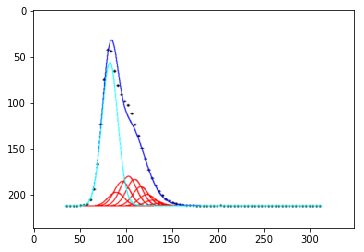

In [91]:
# Choose an index 
index = 5
# Print labels for this index
print("label: " + str(good_fits[index]))
print("prediction: " + str(predictions[index]))

# Show image
this_image = test_images[index]
plt.imshow(np.uint8(nn_utils.get_printable_image(this_image)))

##### Save convolutional model to disc

In [97]:
#plot_model(simple_model, to_file='simple_model.png')
#SVG(model_to_dot(simple_model).create(prog='dot', format='svg'))

# serialize model to JSON
model_json = conv_model.to_json()
with open("conv_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
conv_model.save_weights("conv_model.h5")
print("Saved model to disk")

Saved model to disk
